### Collaborative filtering


In [28]:
import pandas as pd
import numpy as np 
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix
from datetime import timedelta

In [29]:
#path to the mindsmall training data
training_dataset = '../MINDsmall_train'

validation_dataset = '../MINDsmall_train'

entity_embedding = pd.read_csv("../MINDsmall_train/entity_embedding.vec", sep='\t')
relation_embedding = pd.read_csv("../MINDsmall_train/relation_embedding.vec", sep='\t')


news_data = pd.read_csv("../MINDsmall_train/news.tsv",
    sep='\t',
    names=["newsId", "category", "subcategory", "title","abstract", "url", "title_entities","abstract_entities"]
)

behaviors_data = pd.read_csv(
    "../MINDsmall_train/behaviors.tsv",
    sep='\t',
    names=["impressionId", "userId", "timestamp", "click_history", "impressions"],
    parse_dates=['timestamp'] 
)

### Preprocess data

In [30]:
behaviors_data['timestamp'] = pd.to_datetime(behaviors_data['timestamp'], format='%Y-%m-%d %H:%M:%S')
behaviors_data['hour_of_day'] = behaviors_data['timestamp'].dt.hour
behaviors_data['clicks'] = behaviors_data['click_history'].str.split().str.len()
behaviors_data['impressions_list'] = behaviors_data['impressions'].str.split()
behaviors_data['impressions_count'] = behaviors_data['impressions_list'].str.len()

# remove null values
news_data = news_data.dropna().reset_index(drop=True)


### Remove the null values for the clicks & impressions

In [31]:
null_clicks_rows = behaviors_data[behaviors_data['clicks'].isnull() & behaviors_data['click_history'].isnull()]

# Remove the rows with null values
behaviors_data = behaviors_data.dropna().reset_index(drop=True)

In [32]:
# sort behaviors_data by timestamp
behaviors_data = behaviors_data.sort_values(by='timestamp')

In [33]:
news_data.head()

,newsId,category,subcategory,title,abstract,url,title_entities,abstract_entities
0,N55528,lifestyle,lifestyleroyals,"The Brands Queen Elizabeth, Prince Charles, an...","Shop the notebooks, jackets, and more that the...",https://assets.msn.com/labs/mind/AAGH0ET.html,"[{""Label"": ""Prince Philip, Duke of Edinburgh"",...",[]
1,N19639,health,weightloss,50 Worst Habits For Belly Fat,These seemingly harmless habits are holding yo...,https://assets.msn.com/labs/mind/AAB19MK.html,"[{""Label"": ""Adipose tissue"", ""Type"": ""C"", ""Wik...","[{""Label"": ""Adipose tissue"", ""Type"": ""C"", ""Wik..."
2,N61837,news,newsworld,The Cost of Trump's Aid Freeze in the Trenches...,Lt. Ivan Molchanets peeked over a parapet of s...,https://assets.msn.com/labs/mind/AAJgNsz.html,[],"[{""Label"": ""Ukraine"", ""Type"": ""G"", ""WikidataId..."
3,N53526,health,voices,I Was An NBA Wife. Here's How It Affected My M...,"I felt like I was a fraud, and being an NBA wi...",https://assets.msn.com/labs/mind/AACk2N6.html,[],"[{""Label"": ""National Basketball Association"", ..."
4,N38324,health,medical,"How to Get Rid of Skin Tags, According to a De...","They seem harmless, but there's a very good re...",https://assets.msn.com/labs/mind/AAAKEkt.html,"[{""Label"": ""Skin tag"", ""Type"": ""C"", ""WikidataI...","[{""Label"": ""Skin tag"", ""Type"": ""C"", ""WikidataI..."


In [34]:
behaviors_data.head()

,impressionId,userId,timestamp,click_history,impressions,hour_of_day,clicks,impressions_list,impressions_count
19705,20112,U65916,2019-11-09 00:00:19,N51706 N40767 N12096 N9798 N38802 N54827 N5780...,N54300-0 N46057-1 N57005-0 N52154-0 N57099-0 N...,0,15.0,"[N54300-0, N46057-1, N57005-0, N52154-0, N5709...",31
13531,13807,U49985,2019-11-09 00:01:13,N5056 N29975 N53234 N39603 N50032 N8422 N53580...,N20602-0 N50059-0 N57768-1 N50135-1 N15134-0 N...,0,93.0,"[N20602-0, N50059-0, N57768-1, N50135-1, N1513...",29
27115,27660,U25550,2019-11-09 00:02:44,N17260 N38298 N33976 N47719 N14888 N18870 N4607,N50135-0 N15134-0 N52433-1 N20602-0 N64536-0,0,7.0,"[N50135-0, N15134-0, N52433-1, N20602-0, N6453...",5
149080,152217,U19710,2019-11-09 00:02:50,N3530 N48284 N43019 N62546 N138 N13138 N10676 ...,N57099-0 N30295-0 N21086-0 N5379-0 N57005-0 N4...,0,8.0,"[N57099-0, N30295-0, N21086-0, N5379-0, N57005...",56
41348,42166,U38106,2019-11-09 00:03:09,N16874 N264 N48697 N51366,N3491-0 N20602-0 N25785-0 N23575-0 N38783-0 N1...,0,4.0,"[N3491-0, N20602-0, N25785-0, N23575-0, N38783...",48


### Sliding window
Our sliding window is split into 6 hours for training and 3 hours for validation.

In [35]:
train_window_size = 6
test_window_size = 3

start_time = 0
end_time = train_window_size
recommendations = []


def sliding_window(start_time, training_window_size, test_window_size=3):
    end_time = training_window_size
    training_data = behaviors_data[(behaviors_data['timestamp'] >= start_time) & (behaviors_data['timestamp'] < end_time)]
    test_data = behaviors_data[(behaviors_data['timestamp'] >= end_time) & (behaviors_data['timestamp'] < end_time + test_window_size)]

    return training_data, test_data


### Interaction matrix
For each article in the click history of each user interaction in the behaviors data, a 1 is added to the matrix.

In [36]:
def user_clicks(training_data):
    all_clicks = []
    for index, row in training_data.iterrows():
        user_id = row['userId']
        timestamp = row['timestamp']
        for news_id in row['click_history'].split():
            all_clicks.append([user_id, news_id, 1, timestamp])
    clicks_df = pd.DataFrame(all_clicks, columns=['userId', 'newsId', 'click', 'timestamp'])
    return clicks_df

### Cosine similarity

In [37]:
def create_matrix(clicks_df):
    interaction_matrix = clicks_df.pivot_table(index='userId', columns='newsId', values='click', fill_value=0)
    return interaction_matrix

def get_similarity_df(interaction_matrix):
    interaction_sparse = csr_matrix(interaction_matrix.values)
    item_similarity = cosine_similarity(interaction_sparse.T)
    item_similarity_df = pd.DataFrame(item_similarity, index=interaction_matrix.columns, columns=interaction_matrix.columns)
    # use SVD to reduce dimensionality
    return item_similarity_df

### Collaborative filtering with sliding window
We allowed the sliding window to grow up to 72 hours as it allows for detailed data, and can give us more insight into evaluation metrics such as the coverage.

In [39]:
INITIAL_WINDOW_SIZE = 6
MAX_WINDOW_SIZE = 72
SLIDE_SIZE = 3
behaviors_data = behaviors_data.head(10000)
hits_per_window = {}

total_hits = 0
total_rows = 0
hit_rate_list = []

start_time = behaviors_data['timestamp'].min()
end_time = start_time + pd.Timedelta(hours=INITIAL_WINDOW_SIZE)

training_data = behaviors_data[(behaviors_data['timestamp'] >= start_time) & (behaviors_data['timestamp'] < end_time)]
evaluation_data = behaviors_data[(behaviors_data['timestamp'] >= end_time) & (behaviors_data['timestamp'] < end_time + pd.Timedelta(hours=test_window_size))]
print(training_data.shape)
print(evaluation_data.shape)

def get_data_split(start_time, end_time, test_window_size=SLIDE_SIZE):
    # returns a training and evaluation split
    training_data = behaviors_data[(behaviors_data['timestamp'] >= start_time) & (behaviors_data['timestamp'] < end_time)]
    evaluation_data = behaviors_data[(behaviors_data['timestamp'] >= end_time) & (behaviors_data['timestamp'] < end_time + pd.Timedelta(hours=test_window_size))]
    return training_data, evaluation_data

def collaborative_filtering():
    #create matrix based on training split created by sliding window
    similarity_matrix = []
    return similarity_matrix

def recommend(similarity_matrix, evaluation_row):
    #look at the news id in the row. Recommend the top 5 similar news articles
    #last news id in the 'clicks' column is the one that was last clicked
    recommendations = []
    article_id = evaluation_row['click_history'].split()[-1]

    similar_scores = similarity_matrix.get(article_id)
    print(f"Similar scores for article {article_id}: {similar_scores}")

    if similar_scores is not None and not similar_scores.empty:
        recommendations = similar_scores.nlargest(5).index.tolist()
        if article_id in recommendations:
            recommendations.remove(article_id)
    return recommendations

print("TEST")
print(end_time)
print(pd.Timedelta(hours=SLIDE_SIZE))
print(behaviors_data['timestamp'].max())
      

#The sliding window
while end_time + pd.Timedelta(hours=SLIDE_SIZE) <= behaviors_data['timestamp'].max():
    print(f"Start time: {start_time}, End time: {end_time}")
    training_data, evaluation_data = get_data_split(start_time, end_time)

    interaction_matrix = create_matrix(user_clicks(training_data))
    similarity_matrix = get_similarity_df(interaction_matrix)
    
    #recommend for the rows in the evaluation data based on the similiarity matrix we created with the training data
    #evaluate the hit rate based on the recommendations and the impressions in the evaluation row
    hits = 0
    total = 0
    print(f'Shape of evaluation data {evaluation_data.shape}')
    for index, row in evaluation_data.iterrows():
        total += 1
        total_rows += 1
        found_article = False

        clicked_article = []
        recommendations = recommend(similarity_matrix, row)

        [clicked_article.append(n.split("-")[0]) for n in row['impressions_list'] if n.split("-")[1] == "1"]
        # for clicked articles check if any of them are in the recommendations
        for article in clicked_article:
            if article in recommendations:
                found_article = True
        if found_article:
            hits += 1
            total_hits += 1
            hit_rate_list.append(total_hits/total_rows)
            print(f'Hit for user {row['userId']} with articles {clicked_article} and recommendations {recommendations}')



        # if clicked_article in recommendations:
        #     hits += 1
        #     print(f'Hit for user {index} with article {clicked_article} and recommendations {recommendations}')

        print(f'Recommendations for user {row['userId']}: {recommendations}')
        print(f'Actual click for user {row['userId']}: {clicked_article}')
    hits_per_window[(start_time, end_time)] = (hits, total)

    print(f"Start time: {start_time}, End time: {end_time}")
    end_time += pd.Timedelta(hours=SLIDE_SIZE)
    if (end_time - start_time) > pd.Timedelta(hours = MAX_WINDOW_SIZE):
        print("\n")
        print("Increasing start time")
        print("\n")
        #remove data from the beginning of the training data
        start_time += pd.Timedelta(hours=SLIDE_SIZE)



(2591, 9)
(3019, 9)
TEST
2019-11-09 06:00:19
0 days 03:00:00
2019-11-09 15:48:14
Start time: 2019-11-09 00:00:19, End time: 2019-11-09 06:00:19
Shape of evaluation data (3019, 9)
Similar scores for article N28963: newsId
N100      0.0
N10009    0.0
N10016    0.0
N10021    0.0
N10034    0.0
         ... 
N9955     0.0
N996      0.0
N997      0.0
N9973     0.0
N9977     0.0
Name: N28963, Length: 12763, dtype: float64
Recommendations for user U64643: ['N39762', 'N5483', 'N15402', 'N21098']
Actual click for user U64643: ['N41881']
Similar scores for article N15023: newsId
N100      0.0
N10009    0.0
N10016    0.0
N10021    0.0
N10034    0.0
         ... 
N9955     0.0
N996      0.0
N997      0.0
N9973     0.0
N9977     0.0
Name: N15023, Length: 12763, dtype: float64
Recommendations for user U22689: ['N26512', 'N32074', 'N59457', 'N25436']
Actual click for user U22689: ['N41881']
Similar scores for article N8148: newsId
N100      0.000000
N10009    0.000000
N10016    0.000000
N10021    0.00

In [40]:
print(hits_per_window)

{(Timestamp('2019-11-09 00:00:19'), Timestamp('2019-11-09 06:00:19')): (1, 3019), (Timestamp('2019-11-09 00:00:19'), Timestamp('2019-11-09 09:00:19')): (0, 2122), (Timestamp('2019-11-09 00:00:19'), Timestamp('2019-11-09 12:00:19')): (5, 1805)}


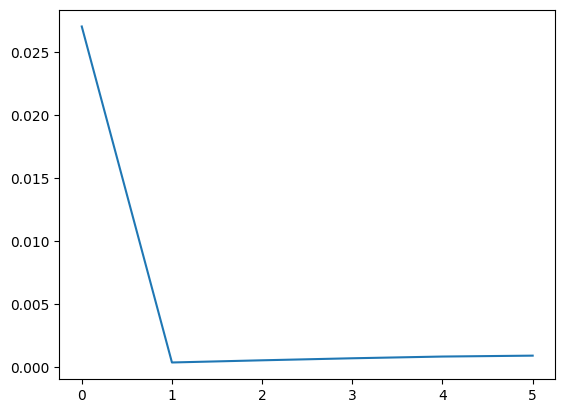

Total hits: 6
Total rows: 6946
Hit rate: 0.0008638065073423554


In [41]:
# use the hit rate list to plot the hit rate over time
import matplotlib.pyplot as plt

plt.title(f'Hit Rate - Bag Of Words')
plt.plot(hit_rate_list)
plt.show()
print(f"Total hits: {total_hits}")
print(f"Total rows: {total_rows}")
print(f"Hit rate: {total_hits/total_rows}")




